In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from crucio import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading dataset 
df = pd.read_csv('data.csv')
df = df.drop_duplicates()
df

,company,rank,rank_change,revenue,profit,num. of employees,sector,city,state,newcomer,ceo_founder,ceo_woman,profitable,prev_rank,CEO,Website,Ticker,Market Cap
0,Walmart,1,0.0,572754.0,13673.0,2300000.0,Retailing,Bentonville,AR,no,no,no,yes,1.0,C. Douglas McMillon,https://www.stock.walmart.com,WMT,352037
1,Amazon,2,0.0,469822.0,33364.0,1608000.0,Retailing,Seattle,WA,no,no,no,yes,2.0,Andrew R. Jassy,www.amazon.com,AMZN,1202717
2,Apple,3,0.0,365817.0,94680.0,154000.0,Technology,Cupertino,CA,no,no,no,yes,3.0,Timothy D. Cook,www.apple.com,AAPL,2443962
3,CVS Health,4,0.0,292111.0,7910.0,258000.0,Health Care,Woonsocket,RI,no,no,yes,yes,4.0,Karen Lynch,https://www.cvshealth.com,CVS,125204
4,UnitedHealth Group,5,0.0,287597.0,17285.0,350000.0,Health Care,Minnetonka,MN,no,no,no,yes,5.0,Andrew P. Witty,www.unitedhealthgroup.com,UNH,500468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Vizio Holding,996,0.0,2124.0,-39.4,800.0,Industrials,Irvine,CA,no,yes,no,no,,William W. Wang,https://www.vizio.com,VZIO,1705.1
996,1-800-Flowers.com,997,0.0,2122.2,118.7,4800.0,Retailing,Jericho,NY,no,no,no,yes,,Christopher G. McCann,https://www.1800flowers.com,FLWS,830
997,Cowen,998,0.0,2112.8,295.6,1534.0,Financials,New York,NY,no,no,no,yes,,Jeffrey Solomon,https://www.cowen.com,COWN,1078
998,Ashland,999,0.0,2111.0,220.0,4100.0,Chemicals,Wilmington,DE,no,no,no,yes,,Guillermo Novo,https://www.ashland.com,ASH,5601.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company            1000 non-null   object 
 1   rank               1000 non-null   int64  
 2   rank_change        1000 non-null   float64
 3   revenue            1000 non-null   float64
 4   profit             997 non-null    float64
 5   num. of employees  999 non-null    float64
 6   sector             1000 non-null   object 
 7   city               1000 non-null   object 
 8   state              1000 non-null   object 
 9   newcomer           1000 non-null   object 
 10  ceo_founder        1000 non-null   object 
 11  ceo_woman          1000 non-null   object 
 12  profitable         1000 non-null   object 
 13  prev_rank          1000 non-null   object 
 14  CEO                1000 non-null   object 
 15  Website            1000 non-null   object 
 16  Ticker             951 no

In [4]:
def preprocess_input(df):
    df = df.copy()

    # Droping unused columns, these columns are not useful for the model, them are unique for each company
    df = df.drop(['company', 'CEO', 'Website', 'Ticker', 'rank', 'prev_rank', 'profit'], axis=1)

    # Mapping yes/no to 1/0
    columns_to_map = ['newcomer', 'ceo_founder', 'ceo_woman', 'profitable']
    for column in columns_to_map:
        df[column] = df[column].map({'yes': 1, 'no': 0})

    # Replace values in Market Cap
    #df['p'] = df['Market Cap'].replace('-', np.nan).astype(float)
    df['Market Cap'] = df['Market Cap'].replace('-', np.nan).astype(float)

    # Dropping non-numerical values
    non_numerical_columns = ['sector', 'city', 'state']
    non_numerical_columns_df = df[non_numerical_columns]
    X_1 = df.drop(['sector', 'city', 'state'], axis=1)

    # Filling missing values
    imputer = KNNImputer(n_neighbors=5)
    # Getting the columns with missing values
    columns_with_missing_values = df.columns[df.isna().any()].tolist()
    for column in columns_with_missing_values:
        missing_column = X_1[column]
        missing_column_2d = missing_column.values.reshape(-1, 1)
        imputed_column_2d = imputer.fit_transform(missing_column_2d)
        X_1[column] = imputed_column_2d.flatten()

    df = pd.concat([X_1, non_numerical_columns_df], axis=1)


    # One hot encoding
    for column in ['sector', 'city', 'state']:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)

    # Balancing data
    smoteenn = SMOTEENN()
    df = smoteenn.balance(df, 'profitable')

    return df

In [5]:
df = preprocess_input(df)
df.head()

,rank_change,revenue,num. of employees,newcomer,ceo_founder,ceo_woman,Market Cap,sector_Aerospace & Defense,sector_Apparel,sector_Business Services,...,state_RI,state_SC,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,profitable
0,0.0,3148.90789,1458.92884,0.0,0.0,0.0,1053.139906,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,6475.485187,1018.802287,0.776789,0.0,0.0,8691.965624,0.0,0.0,0.0,...,0.0,0.0,0.0,0.776789,0.0,0.0,0.0,0.0,0.0,0
2,0.0,4357.679239,30882.996729,0.0,0.0,0.323301,666.788886,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,2186.504979,1807.670553,0.0,0.0,0.0,1455.143809,0.0,0.0,0.0,...,0.0,0.0,0.0,0.913061,0.0,0.0,0.0,0.0,0.0,0
4,0.0,4873.247397,8608.939166,0.0,0.970203,0.0,40806.242891,0.0,0.0,0.0,...,0.0,0.0,0.0,0.029797,0.0,0.0,0.0,0.0,0.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1658 entries, 0 to 998
Columns: 475 entries, rank_change to profitable
dtypes: int64(1), object(474)
memory usage: 6.0+ MB


In [19]:
# Splitting data
y = df['profitable']
X = df.drop('profitable', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set - X:", X_train.shape, "y:", y_train.shape)
print("Test set - X:", X_test.shape, "y:", y_test.shape)


Training set - X: (1326, 474) y: (1326,)
Test set - X: (332, 474) y: (332,)


In [20]:
import pandas as pd

# Assuming df is your DataFrame and it's already cleaned and ready for analysis
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Initialize a list to hold pairs of highly correlated features
high_correlation_pairs = []

# Set a threshold for considering a correlation to be 'high'
high_corr_threshold = 0.8

# Iterate over the correlation matrix and extract the feature pairs with high correlation
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print the pairs of features that have a high correlation
for pair in high_correlation_pairs:
    print(f"Highly correlated pair: {pair[0]} & {pair[1]} with correlation coefficient {correlation_matrix.loc[pair[0], pair[1]]}")


Highly correlated pair: city_Atlanta & state_GA with correlation coefficient 0.8666376402173074
Highly correlated pair: city_Bethesda & state_MD with correlation coefficient 0.8079276486662287
Highly correlated pair: city_Birmingham & state_AL with correlation coefficient 1.0
Highly correlated pair: city_Bismarck & state_ND with correlation coefficient 1.0
Highly correlated pair: city_Boise & state_ID with correlation coefficient 0.8657637251551716
Highly correlated pair: city_Denver & state_CO with correlation coefficient 0.8202530721618652
Highly correlated pair: city_Hato Rey & state_PR with correlation coefficient 1.0
Highly correlated pair: city_Honolulu & state_HI with correlation coefficient 1.0
Highly correlated pair: city_Las Vegas & state_NV with correlation coefficient 0.8041284390427088
Highly correlated pair: city_Laurel & state_MS with correlation coefficient 1.0
Highly correlated pair: city_Louisville & state_KY with correlation coefficient 0.8160027819222162
Highly corr

In [21]:
from sklearn.preprocessing import StandardScaler

# Scalling data
scaler = StandardScaler()
# Apply to both the train set and the test set. 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Accuracy: 0.8704819277108434
Precision: 0.937984496124031
Recall: 0.7756410256410257
F1: 0.8491228070175438
ROC AUC: 0.8650932400932402
ROC AUC: 0.8650932400932402
[[168   8]
 [ 35 121]]


<module 'matplotlib.pyplot' from 'C:\\Users\\Simion\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

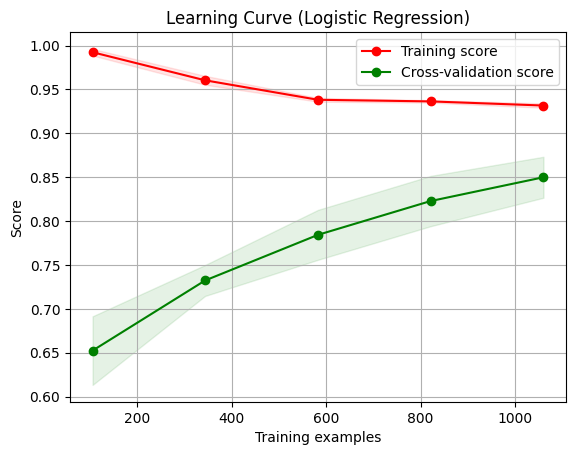

In [26]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')
f1 = f1_score(y_test, y_pred)
print(f'F1: {f1}')
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc}')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

plot_learning_curve(logistic_model, 'Learning Curve (Logistic Regression)', X_train, y_train, cv=5)

Accuracy: 0.9879518072289156
[[173   3]
 [  1 155]]


<module 'matplotlib.pyplot' from 'C:\\Users\\Simion\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

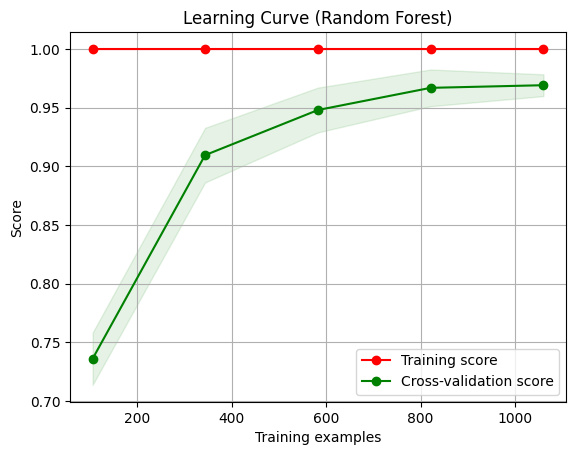

In [24]:
# Random Forest
# Create a RandomForestClassifier
clf_forest = RandomForestClassifier()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 150, 200],  
    'max_depth': [None, 25, 50], 
}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf_forest, param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a RandomForestClassifier with the best parameters
clf_forest = RandomForestClassifier( n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])

# Fit the model
clf_forest.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf_forest.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot the learning curve
plot_learning_curve(clf_forest, 'Learning Curve (Random Forest)', X_train, y_train, cv=5)

Accuracy: 0.9518072289156626
Precision: 0.9545454545454546
Recall: 0.9423076923076923
F1: 0.9483870967741935
ROC AUC: 0.9512674825174825
ROC AUC: 0.9512674825174825
[[169   7]
 [  9 147]]


<module 'matplotlib.pyplot' from 'C:\\Users\\Simion\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

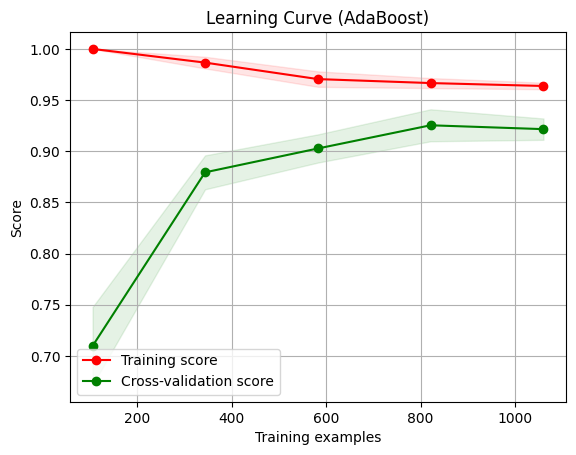

In [27]:
# AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
class_weights = {0: 2, 1: 1}
# Create a DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(max_depth=1, class_weight=class_weights, random_state=42)

# Create an AdaBoostClassifier
clf_adaboost = AdaBoostClassifier(base_estimator=clf_tree, random_state=42)

# Fit the AdaBoostClassifier
clf_adaboost.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf_adaboost.predict(X_test)

# Print the metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

f1 = f1_score(y_test, y_pred)
print(f'F1: {f1}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print(f'ROC AUC: {roc_auc}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot the learning curve
plot_learning_curve(clf_adaboost, 'Learning Curve (AdaBoost)', X_train, y_train, cv=5)


In [129]:
# Feature importance
from pandas import DataFrame as df
feature_importances = df(clf_forest.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

feture_importances = feature_importances.head(10)

# Plot the feature importances
feture_importances.plot(kind='barh')
plt.title('Feature Importances')


ValueError: Shape of passed values is (2, 1), indices imply (474, 1)

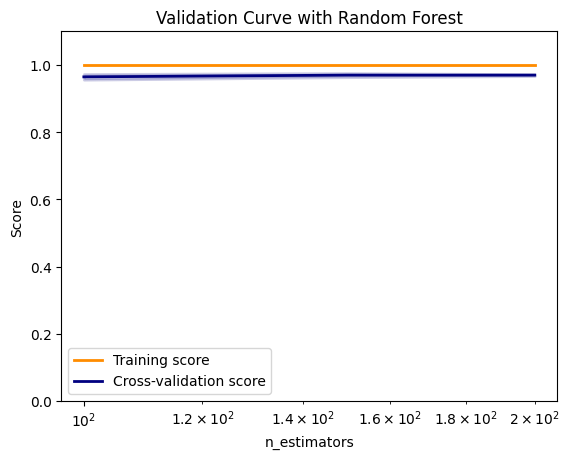

In [74]:
# Curve fitting in points of data
from sklearn.model_selection import validation_curve
param_range = [100, 150, 200]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X_train, y_train, param_name="n_estimators", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


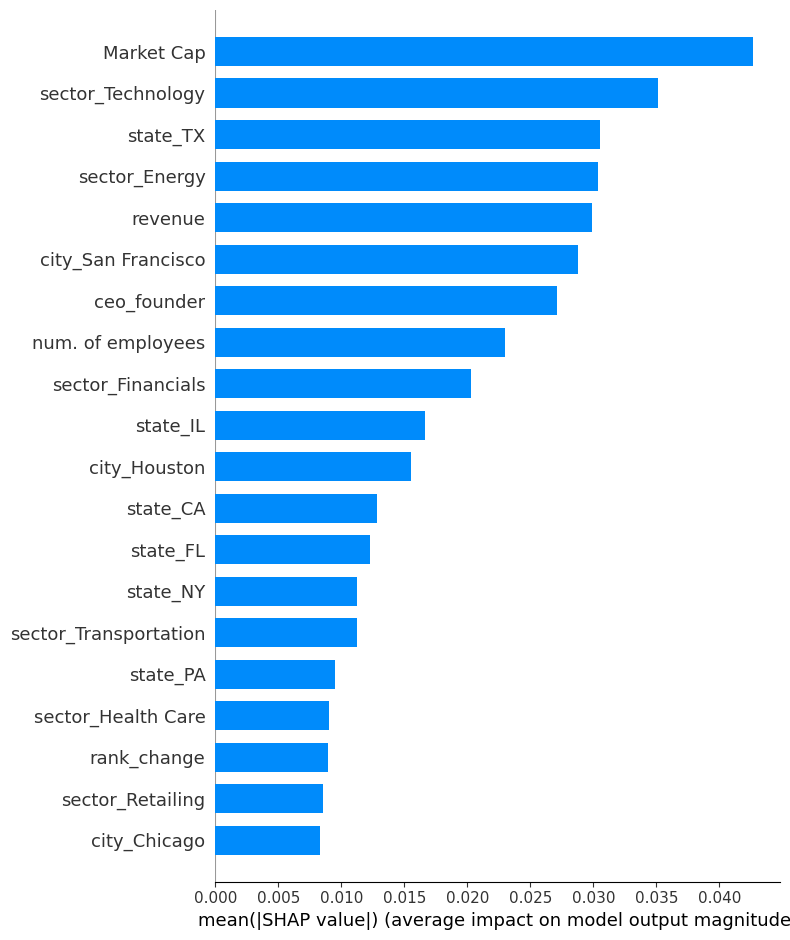

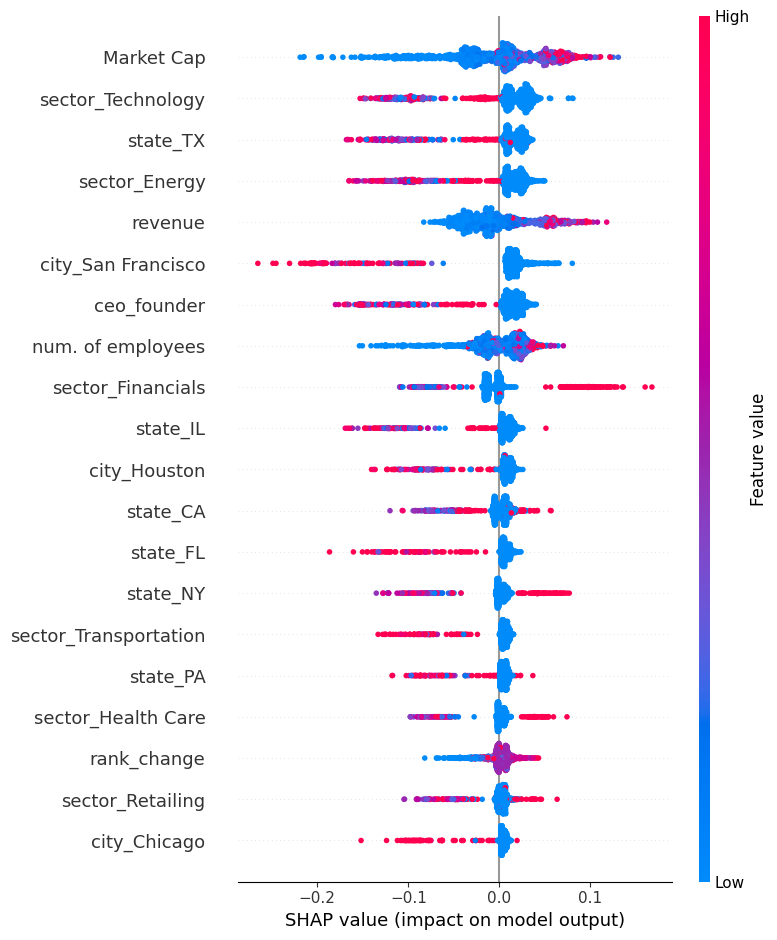

In [ ]:
import shap
import pandas as pd

shap.initjs()

# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_forest)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Extract feature names from X_train
feature_names = X_train_df.columns.tolist()

# Plot the SHAP values
shap.summary_plot(shap_values[1], X_train_df, plot_type="bar", feature_names=feature_names)

# Plot the SHAP values
shap.summary_plot(shap_values[1], X_train_df, feature_names=feature_names)



In [114]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier


# Create a DecisionTreeClassifier
clf = GradientBoostingClassifier()

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 6, 9],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a DecisionTreeClassifier with the best parameters
clf = GradientBoostingClassifier(max_depth=best_params['max_depth'])

# Fit the model
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot the learning curve
plot_learning_curve(clf, 'Learning Curve (Decision Tree)', X_train, y_train, cv=5)


KeyboardInterrupt: 

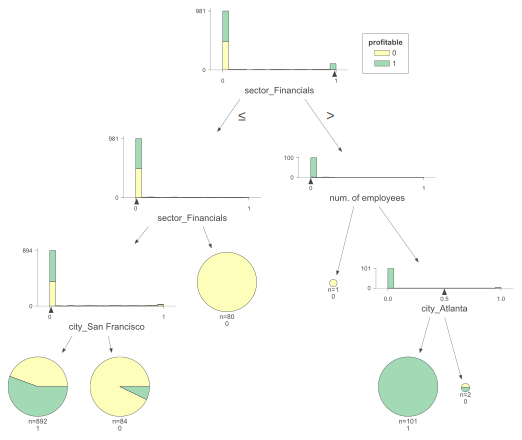

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import dtreeviz

# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the model
clf.fit(X_train, y_train)


# Convert X_train and y_train to pandas DataFrames
X_df = pd.DataFrame(X_train, columns=X.columns)
y_df = pd.Series(y_train, name='profitable')

viz = dtreeviz.model(clf,
                     X_df,
                     y_df,
                     target_name='profitable',
                     feature_names=X_df.columns,
                     class_names=[str(i) for i in np.unique(y_train)]
                    )

# Displaying the tree visualization
viz.view()

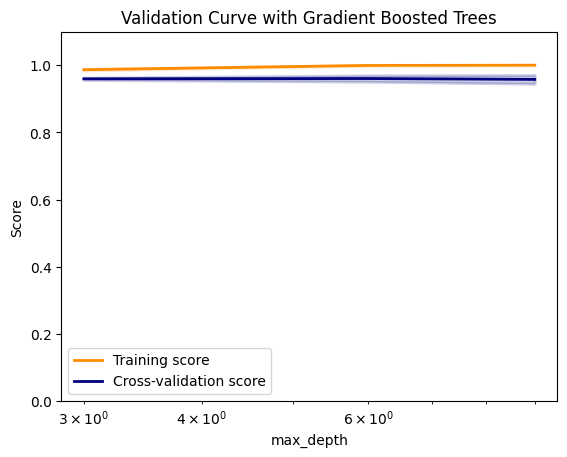

In [ ]:
# Validation curve
from sklearn.model_selection import validation_curve
param_range = [3, 6, 9]
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(), X_train, y_train, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosted Trees")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

<module 'matplotlib.pyplot' from 'C:\\Users\\Simion\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

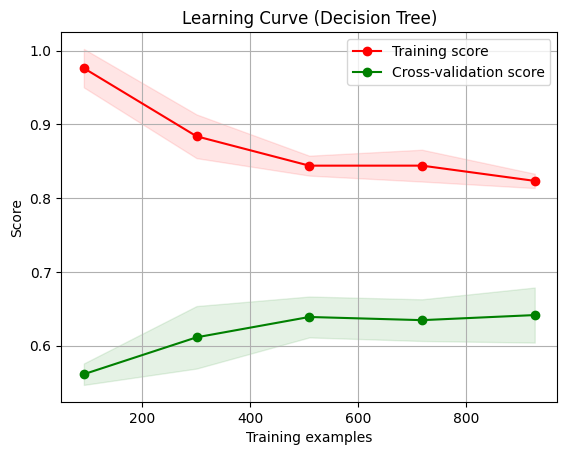

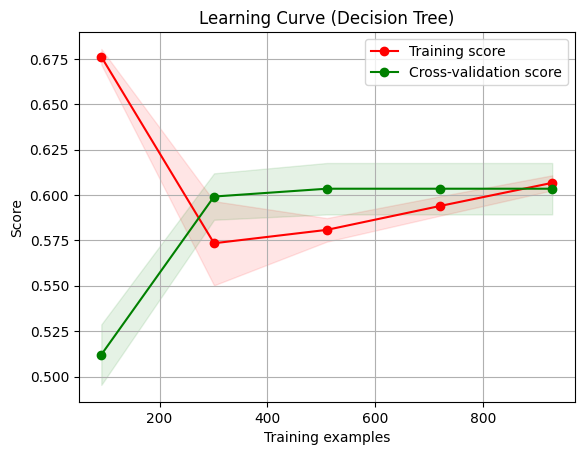

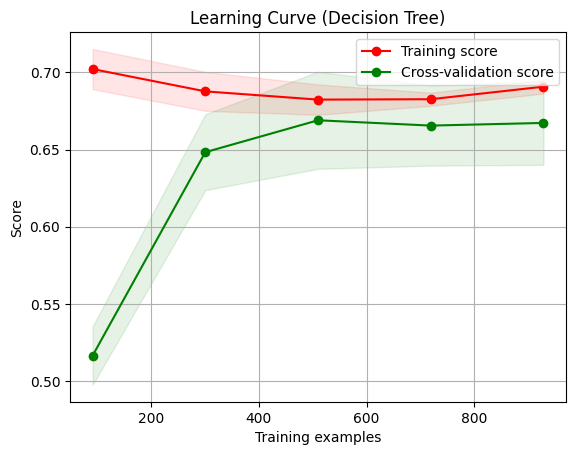

In [131]:
# Learning curve of an Overfittded model
# Create a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=9)

# Fit the model
clf.fit(X_train, y_train)

# Plot the learning curve
plot_learning_curve(clf, 'Learning Curve (Decision Tree)', X_train, y_train, cv=5)

# Learning curve of an Underfittded model
# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=1)

# Fit the model
clf.fit(X_train, y_train)

# Plot the learning curve
plot_learning_curve(clf, 'Learning Curve (Decision Tree)', X_train, y_train, cv=5)

# Learning curve of a well-fitted model
# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the model
clf.fit(X_train, y_train)

# Plot the learning curve
plot_learning_curve(clf, 'Learning Curve (Decision Tree)', X_train, y_train, cv=5)
